## Importação de bibliotecas

In [2]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from imblearn.over_sampling import SMOTE
import datetime
import warnings
warnings.filterwarnings('ignore')

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from unidecode import unidecode

from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import plot_roc_curve

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

## Carregamento do dataset

In [3]:
df = pd.read_feather('../data/carteira_total.feather')


## Data Preparation

### Correção da nomenclatura das colunas

In [4]:
newColumnsName = []
for column_name in df:
  newColumnsName.append(
      re.sub('[^A-Za-z0-9]+', '_', unidecode(column_name).lower()))
df.columns = newColumnsName


### Criação da variável target

In [5]:
df["upsale_downsale"].replace(
    {"Churn": "churn", "Upsell": "upsell", "Downsell": "downsell", "Ok": "ok"}, inplace=True)
df['churn'] = df['upsale_downsale']
df['churn'].replace(
    {"ok": "0", "upsell": "0", "downsell": "0", "churn": "1"}, inplace=True)

df.drop(columns=["upsale_downsale"], inplace=True)


### Criação da variável "quantidades mês" (feature engeneering com a variável nativa "mês")

In [6]:
df_grouped = df[['mes', 'id_sap']].groupby(['id_sap']).count().reset_index()

df_grouped.rename(columns = {'mes':'quantidade_mes'}, inplace=True)

In [7]:
df = df.join(df_grouped.set_index('id_sap'), on='id_sap')

### Criação da variável "status_pagamento" (feature engeneering utilizando fonte de dados externa)

In [8]:
xls = pd.ExcelFile('../data/quality_score.xlsx')
xls.sheet_names

i = 0
for data in xls.sheet_names:
    if i == 0:
        dfQuality = pd.read_excel(xls, data)
        dfQuality['data'] = data
        dfQuality.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                  'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)
    else:
        dfQualityAux = pd.read_excel(xls, data)
        dfQualityAux['data'] = data
        dfQualityAux.rename(columns={'Classificação Pagamento': 'status_pagamento', 'Quality Score Cobrança': 'status_pagamento',
                                     'PFIN': 'status_pagamento', 'PEFIN': 'status_pagamento'}, inplace=True)

        dfQuality = pd.concat([dfQuality, dfQualityAux])

    i+=1

In [9]:
dfQuality['status_pagamento'].replace({'4. Péssimo': 'Pessimo', '2. Regular ': 'Regular', '1. Bom': 'Bom', '3. Ruim': 'Ruim', '5. Novo': 'Novo',
                                       '2. Regular': 'Regular', '1. Bom ': 'Bom', 'lançamentos': np.nan, '5. novo': 'Novo', 0: np.nan}, inplace=True)


In [10]:
dfQuality.dropna(inplace=True)


In [11]:
regex = r'([0-9]{4})-([0-9]{2})-[0-9]{2}'


def fun_replace(data):
    return datetime.datetime.strptime(str(data.group(2)).lower(), '%m').strftime('%b').lower() + data.group(1)[-2:]


df['mes'] = df['mes'].astype(str).str.replace(regex, fun_replace, regex=True)


In [12]:
dfQuality.rename(columns={'ID SAP': 'id_sap', 'data': 'mes'}, inplace=True)


In [13]:
df = df.join(dfQuality.set_index(['id_sap', 'mes']), on=['id_sap', 'mes'])


### Correção dos valores de colunas categóricas

In [14]:
df['oficina'].replace({'wi': 'WI'}, inplace=True)

In [15]:
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.lower()


In [16]:
df['frequencia_de_faturamento'] = df['frequencia_de_faturamento'].str.strip()


In [17]:
df['frequencia_de_faturamento'].replace(
    {'única vez': 'unica_vez'}, inplace=True)


In [18]:
df['equipe'].replace({'Relacionamento': 'RELACIONAMENTO', 'Jumbo': 'JUMBO',
                     'Resellers': 'RESELLERS', 'Regional DF': 'REGIONAL DF'}, inplace=True)


### Drop de colunas com valores inutilizáveis

In [19]:
df.drop(['contratado_freemium', 'utilizado_freemium'], axis=1, inplace=True)


### Tratamento de valores nulos

In [20]:
numericalColumns = df.select_dtypes(include=np.number)

df = df[df['status_pagamento'].notna()]
df[numericalColumns.columns] = numericalColumns.fillna(
    numericalColumns.median())

for col in numericalColumns:
    df[col][df[col] < 1] = 1


### Seleção das colunas mais significativas

In [21]:
df = df[['pf_pj', 'contratado_ofertas_simples', 'utilizado_ofertas_simples',
         'leads_form', 'equipe', 'utilizado_destaque', 'valor_mensal',
         'quantidade_mes', 'status_pagamento', 'churn', 'regiao', 'oficina', 'tipo_de_plano', 'frequencia_de_faturamento']]

## Modeling

### Tratamento de variáveis categóricas

In [22]:
dummy_df = pd.get_dummies(df[[
    'pf_pj', 'equipe', 'status_pagamento', 'regiao', 'oficina', 'tipo_de_plano', 'frequencia_de_faturamento']], drop_first=True)
df = df.join(dummy_df)
df.drop(columns=['pf_pj', 'equipe', 'status_pagamento', 'regiao',
        'oficina', 'tipo_de_plano', 'frequencia_de_faturamento'], inplace=True)


### Data split

In [23]:
X = df.drop(['churn'], axis=1)
y = df['churn'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=1)

X_train = pd.DataFrame(X_train, columns=X_train.columns)
y_train = pd.Series(y_train)

X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, random_state=1)  # 0.25 x 0.8 = 0.2


### Tratamento de dados numéricos

In [24]:
def trataDados(df_dados, target):
    # Balanceamento dos dados
    sm = SMOTE(sampling_strategy='minority', random_state=7)
    df_dados, target = sm.fit_resample(df_dados, target.filter(df_dados.index))

    # Normalização dos dados
    numericalColumns = ['contratado_ofertas_simples', 'utilizado_ofertas_simples', 'leads_form',
                        'utilizado_destaque', 'valor_mensal', 'quantidade_mes']
    df_dados[numericalColumns] = RobustScaler(
    ).fit_transform(df_dados[numericalColumns])

    return df_dados, target


In [25]:
X_train, y_train = trataDados(X_train, y_train)
X_val, y_val = trataDados(X_val, y_val)
X_test, y_test = trataDados(X_test, y_test)


### Execução do Modelo

In [26]:
def executeModel(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y=y_train)

    predictDataSet = model.predict(X_test)

    f1 = round(f1_score(y_test, predictDataSet, average='macro')*100, 2)
    accuracy = round(accuracy_score(y_test, predictDataSet)*100, 2)
    precision = round(precision_score(y_test, predictDataSet)*100, 2)
    recall = round(recall_score(y_test, predictDataSet)*100, 2)

    print(f"F1 Score: {f1}%")
    print(f"Accuracy Score: {accuracy}%")
    print(f"Precision Score: {precision}%")
    print(f"Recall Score: {recall}%")

    plot_confusion_matrix(model, X_test, y_test, display_labels=[
        "positivo", "negativo"], values_format="d")
    plt.grid(False)
    plt.show()

    plot_roc_curve(model, X_test, y_test)
    plt.show()


Random Forest
------------------------------
F1 Score: 89.46%
Accuracy Score: 89.47%
Precision Score: 91.96%
Recall Score: 86.5%


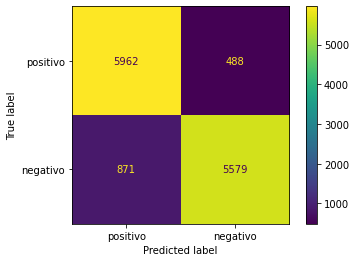

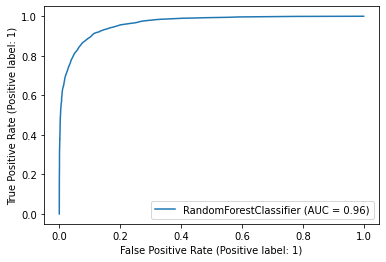


Gradient Boosting
------------------------------
F1 Score: 88.6%
Accuracy Score: 88.62%
Precision Score: 85.49%
Recall Score: 93.02%


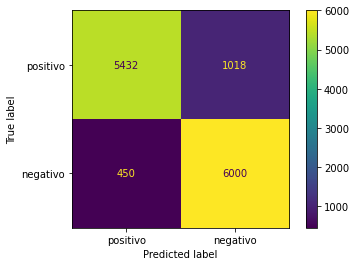

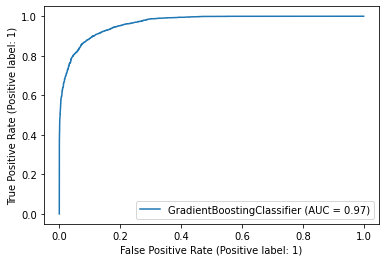


Multilayer Perceptron
------------------------------
Iteration 1, loss = 0.35079312
Iteration 2, loss = 0.24163514
Iteration 3, loss = 0.23658298
Iteration 4, loss = 0.23187912
Iteration 5, loss = 0.22914637
Iteration 6, loss = 0.22765960
Iteration 7, loss = 0.22240383
Iteration 8, loss = 0.22110828
Iteration 9, loss = 0.22150995
Iteration 10, loss = 0.21721521
Iteration 11, loss = 0.21812671
Iteration 12, loss = 0.21660841
Iteration 13, loss = 0.21463052
Iteration 14, loss = 0.21663670
Iteration 15, loss = 0.21506242
Iteration 16, loss = 0.21494938
Iteration 17, loss = 0.21356931
Iteration 18, loss = 0.21081665
Iteration 19, loss = 0.21235876
Iteration 20, loss = 0.21173956
Iteration 21, loss = 0.21108871
Iteration 22, loss = 0.20955401
Iteration 23, loss = 0.20892902
Iteration 24, loss = 0.20917571
Iteration 25, loss = 0.21123029
Iteration 26, loss = 0.21123372
Iteration 27, loss = 0.20955712
Iteration 28, loss = 0.20696017
Iteration 29, loss = 0.20767659
Iteration 30, loss = 0.2083

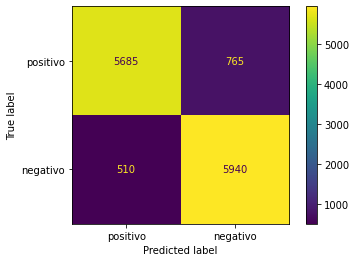

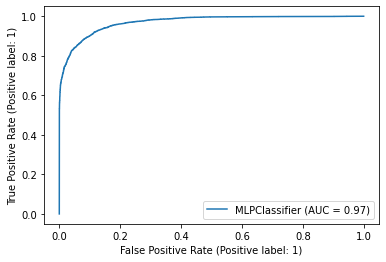


KNN
------------------------------
F1 Score: 86.4%
Accuracy Score: 86.4%
Precision Score: 87.52%
Recall Score: 84.91%


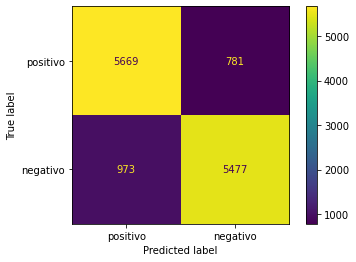

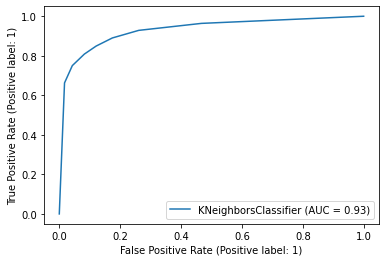

In [27]:
print('Random Forest')
print('-' * 30)
executeModel(RandomForestClassifier(n_jobs=-1, random_state=1),
             X_train, y_train, X_val, y_val)
print()
print('Gradient Boosting')
print('-' * 30)
executeModel(GradientBoostingClassifier(
    random_state=1), X_train, y_train, X_val, y_val)
print()
print('Multilayer Perceptron')
print('-' * 30)
executeModel(MLPClassifier(hidden_layer_sizes=(6, 5),
                           random_state=1,
                           verbose=True,
                           learning_rate_init=0.01), X_train, y_train, X_val, y_val)
print()
print('KNN')
print('-' * 30)
executeModel(KNeighborsClassifier(n_neighbors=7),
             X_train, y_train, X_val, y_val)
